<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Optimal_growth_model_IV_EGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from interpolation import interp
from quantecon.optimize import brentq

from numba import jit, njit, jitclass, prange, float64, int32
import time
%matplotlib inline

In [3]:
ogm_data=[('alpha', float64),
     ('beta', float64),
     ('k_grids', float64[:]),
     ('mc_shocks', float64[:]),
     ('gamma', float64),
     ('mu', float64),
     ('s', float64)
    ]

@jitclass(ogm_data)
class OptimalGrowthModel:
  def __init__(self, alpha=0.4,
             beta=0.96,       
             mu=0,          # shock location parameter
             s=0.1,        # shock scale parameter
             gamma=1.5,
             grid_min=1e-4,
             grid_max=4,
             grid_size=120,
             shock_size=250,
             seed=1234):
    
    self.alpha, self.beta = alpha, beta
    self.k_grids = np.linspace(grid_min, grid_max, grid_size)
    self.mu, self.s = mu, s
    np.random.seed(seed)
    self.mc_shocks = np.exp(mu + s*np.random.randn(shock_size))
    self.gamma = gamma

  def u(self, c):
    gamma = self.gamma
    return np.log(c) if gamma == 1 else c**(1-gamma)/(1-gamma) 
  
  def u_prime(self, c):
    gamma = self.gamma
    return 1/c if gamma==1 else c**(-gamma) 
  
  def u_prime_inverse(self, u):
    gamma = self.gamma
    return 1/u if gamma==1 else u**(-1/gamma)
  
  def f(self, k):
    return k**self.alpha
  
  def f_prime(self, k):
    alpha = self.alpha
    return alpha*k**(alpha-1)
  

@njit
def compute_consumption(k, y_grids, sigma, ogm):
  u_prime, u_prime_inverse, f, beta, z, f_prime = ogm.u_prime, ogm.u_prime_inverse, ogm.f, ogm.beta, ogm.mc_shocks, ogm.f_prime
  fun_sigma = lambda x: interp(y_grids, sigma, x)
  fv = u_prime(fun_sigma(f(k)*z))*f_prime(k)*z
  c = u_prime_inverse(beta*fv.mean())
  return c


@njit(parallel=True)
def K(sigma, ogm):
  Ksigma = np.empty_like(sigma)
  y_grids = ogm.k_grids + sigma
  for i in prange(len(ogm.k_grids)):
    val = ogm.k_grids[i]
    if val < 1e-12:
      Ksigma[i] = 0
    else:
      Ksigma[i] = compute_consumption(val, y_grids, sigma, ogm)
  return Ksigma


def compute_policy_function(ogm, max_iter=500, tol=1e-6, verbose=True):
  sigma = np.copy(ogm.k_grids)

  i = 0
  err = 1 + tol

  while i < max_iter and err > tol:
    Ksigma = K(sigma, ogm)
    i += 1
    err = np.max(np.abs(Ksigma - sigma))
    sigma = Ksigma
    if verbose and i%25==0:
      print(f'Error is {err} at interation {i}.')
    
  if i == max_iter:
    raise RuntimeError('Iteration failed.')
  
  if verbose:
    print(f'\nConverged on interation {i}!')

  return sigma

In [7]:
%%time

ogm = OptimalGrowthModel(gamma=1, grid_min=0)
sigma = compute_policy_function(ogm)


Converged on interation 17!
CPU times: user 40.3 ms, sys: 1.07 ms, total: 41.4 ms
Wall time: 48.7 ms


In [5]:
def v_star(y, ogm):
  alpha, beta, mu = ogm.alpha, ogm.beta, ogm.mu
  left = np.log(1-alpha*beta)/(1-beta)
  middle = (mu+alpha*np.log(alpha*beta))/(1-alpha)*(1/(1-beta) - 1/(1-alpha*beta))
  right = np.log(y)/(1-alpha*beta)
  return left + middle + right

def sigma_star(y, ogm):
  alpha, beta = ogm.alpha, ogm.beta
  return (1-alpha*beta)*y

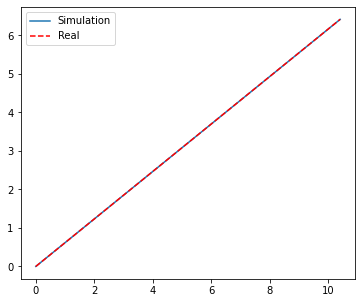

In [6]:
y_grids = sigma + ogm.k_grids
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(y_grids, sigma, label='Simulation')
ax.plot(y_grids, sigma_star(y_grids, ogm), 'r--', label='Real')
ax.legend();